# Initial Data Inspection

Walter Muruet

## 1 Data Acquisition Process

The `vax_tweets.csv` file was created from data obtained by accessing
Tweets between 2020-08-09 to 2022-09-14 with the hashtag #CovidVaccine,
according to the data providers (Wellcome Ideathon 2023 team).

> **Caution**
>
> However, as we will see below, about 15% of the data set’s entries
> have missing values for hashtags, possibly suggesting an slightly
> different data acquisition process that the one described.

## 2 A First Look at the Data

Using `dplyr::glimpse()` we can appreciate the data contains 100,000
examples of Tweets each one described by ten features. Four features are
of type characters (`user_location`, `user_description`, `text` and
`hashtags`), three are numeric/integers (`user_followers`,
`user_friends`, `user_favourites`), two are logical (`user_verified`,
`is_retweet`) and one is date (`date`).

Based on this information, we may want to do some data preparation
before proceeding with any further data inspection. We will do this in
the next section ([Data Preparation](#sec-data_prep))

In [ ]:
dplyr::glimpse(tweets_df)

Rows: 100,000
Columns: 10
$ user_location    <chr> "Chicago", "Bengaluru, India", NA, NA, "not in London…
$ user_description <chr> "Official Twitter of Mercy Home for Boys & Girls, a s…
$ user_followers   <int> 4352, 40, 1915, 144, 184, 1539, 446, 2232084, 96, 142…
$ user_friends     <int> 2087, 0, 860, 329, 98, 1209, 406, 373, 498, 121, 513,…
$ user_favourites  <int> 1780, 0, 52127, 15876, 13359, 210, 6271, 110, 7396, 6…
$ user_verified    <lgl> TRUE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, TRUE,…
$ date             <date> 2021-03-12, 2022-03-10, 2021-10-19, 2021-07-02, 2021…
$ text             <chr> "We asked our coworkers why they're getting a COVID-1…
$ hashtags         <chr> "['FeelGoodFriday', 'MercyHomeCares', 'Covid19']", "[…
$ is_retweet       <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALS…

## 3 Data Preparation

Data preparation consists in the following steps:

1.  Add a `tweet_id` column. This will help us keep track of provenance
    when we start manipulating text fields
2.  Removing leading and trailing square brackets from `hastags`.

In [ ]:
tweets_df <-
    tweets_df %>%
    dplyr::mutate(
        tweet_id = dplyr::row_number(),
        hashtags = stringr::str_remove_all(hashtags, pattern = '^\\[|\\]$') 
        ) %>%
    dplyr::relocate(tweet_id)

tweets_df %>%
    kreate(3)

## 4 Data Quality

### 4.1 Duplicated observations

In [ ]:
tweets_df %>%
    janitor::get_dupes(-tweet_id) %>%
    dplyr::relocate(tweet_id) %>%
    kreate()

There are no duplicated observations as such. However, `tweet_id`s
32,812, 43,903 and 69,622 have only missing values. These observations
should not have been matched when the tweets were fetched. It is
possible that `vax_tweets.csv` was created by appending csv files
together and these were extra rows at the end of each table. . . At any
rate, these rows are excluded from all the results below.

### 4.2 Missing data

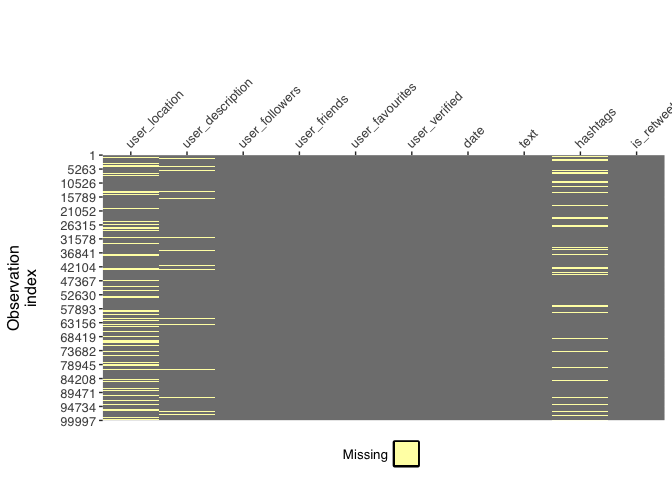

In [ ]:
tweets_df %>%
    dplyr::select(-tweet_id) %>%
    missing_matrix_plot()

[Figure 1](#fig-missing) shows that the columns `user_location`,
`user_description`, and `hashtags` have the greatest amount of missing
values. [Table 1](#tbl-missing) below shows the actual quantities of
missing values per column.

In [ ]:
tweets_df %>%
    dplyr::select(-tweet_id) %>%
    missing_prop_table() %>%
    kreate()

## 5 Tweets Over Time

`vax_tweets.csv` contains tweets from the years 2020,2021 and 2022. The
earliest tweet happened on 09 August of 2020 and the last tweet 14
September of 2022. [Figure 2](#fig-tweets-timeline) below shows the
number of tweets aggregated at the week level. The rug is meant to give
a sense of the amount of verified users each week.

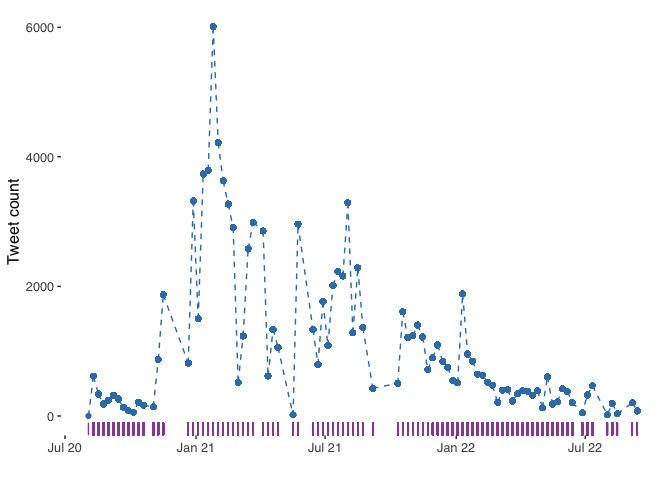

In [ ]:
tweets_df %>%
    dplyr::transmute(date,
                     week = cut.Date(date, breaks = '1 week'),
                     week = as.Date(week),
                     verified = user_verified) %>%
    dplyr::group_by(week) %>%
    dplyr::transmute(n = dplyr::n(),
                     verified = sum(verified, na.rm = TRUE)) %>%
    ggplot2::ggplot(mapping = ggplot2::aes(x = week, y = n)) +
    ggplot2::geom_line(linetype = 'dashed', colour = '#377eb8') +
    ggplot2::geom_point(colour = '#377eb8') +
    ggplot2::geom_rug(mapping = ggplot2::aes(y = verified), sides = 'b', colour = '#984ea3') +
    ggplot2::labs(y = 'Tweet count', x = '') +
    ggplot2::scale_x_date(date_labels = '%b %y') +
    ggthemes::theme_tufte() +
    ggplot2::theme(text = ggplot2::element_text(family = 'Helvetica', size = 12))

## 6 Qualitative Data

### 6.1 User location

User location contains a mixture of cities, countries and miscellaneous
information (‘not in London’). Furthermore, places may be written in
full (‘United States’), as abbreviation (‘UK’), as a combination of
state/district and country (‘Bengaluru, India’), city and state
(‘Denver, CO’) among other variations. Additionally, city names are not
unique (‘London, Ontario, Canada’…damn Europeans, lacking creativity…).
These are some issues we need to think about solving if we want to use
location data.

Some potential solutions include:

1.  Not using user location data. Plain, simple and mediocre. Yay!
2.  Leaving it as-it-is (see [Raw user location
    data](#raw-user-location-data))
3.  Adapting/expanding on someone else’s work.
    1.  This could be using code to ‘manually’ harmonise locations
    2.  Use a pre-trained transformer
    3.  A mixture of these two, where we can fine tune a pre-trained
        transformer using some of our ‘manually labeled data’.

Some further considerations:

1.  How much do we care for the cleanliness of location data? For the
    purpose of the prototype we don’t really need a squeaky clean
    `user_location`. Our goal is to produce a proof of concept, and have
    some clear ideas on how we will refine the process afterwards.

2.  Furthermore, even if we do a terrific job cleaning `user_location`,
    its granularity is unlikely to be great for most of the tweets, so
    perhaps the cost-benefit of devoting too much time to this is
    questionable at best.

3.  Let’s think about what we want to do with `user_location` and then
    consider how much does that adds to the project and the final
    result. . .

    #### 6.1.1 Raw user location data

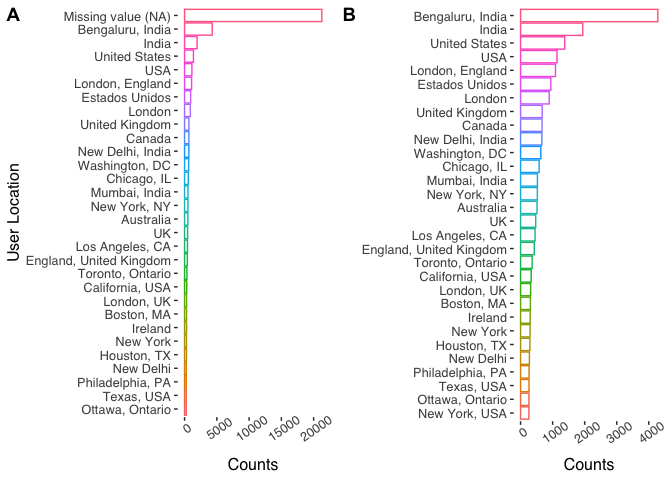

In [ ]:
list(
    .drop_na = list(FALSE,TRUE),
    .y_label = list(NULL,'')) %>%
purrr::pmap(
    univar_cat_bar_plot,
    .dataset = tweets_df,
    .column = 'user_location',
    .n_largest = 30) %>%
    cowplot::plot_grid(plotlist = ., labels = 'AUTO')

In [Figure 3](#fig-raw_user_location) subplot A shows frequencies
including missing values, while in subplot B these were removed. Notice
the difference in the scale between x axes. These represent the raw data
as it is, meaning a bit better mileage could be obtained by doing some
bare minimum data wrangling, such as turning all letter to lower caps.

#### 6.1.2 Manual cleaning of user location data

Adapting the work user
\[ANDRADA\](https://www.kaggle.com/andradaolteanu) did in Kaggle for
cleaning location data of tweets, I have repurpose it into a function to
somewhat clean our data. It’s still a work in progress, though. In
@bl-user_location_manual_01 you can compare a ‘random’ slice of the data
set to judge the results by yourselves.

In [ ]:
tweets_df <- 
    tweets_df %>%
    get_user_country(user_location, country)

set.seed(13)

tweets_df %>%
    dplyr::select(tweet_id, user_location, country) %>%
    dplyr::slice_sample(n = 30) %>%
    kreate()

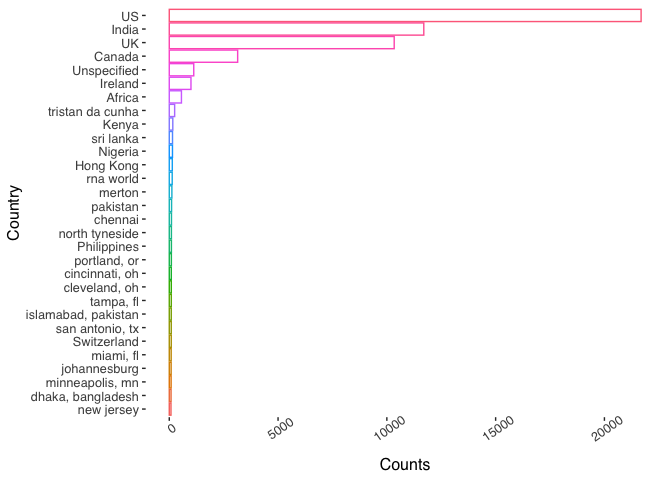

In [ ]:
univar_cat_bar_plot(tweets_df, country, .drop_na = TRUE, .n_largest = 30)

Compare [Figure 4](#fig-user_location_manual_01) with
[Figure 3](#fig-raw_user_location). After some manual cleaning, most
tweets appear to be coming from the US, not India. This is not that
surprising as the hashtags used to extract the data were in English.
However, there is also some bias involve. The list mapping places to the
US is several times longer than the one for India.

#### 6.1.3 Using a pre-trained transformer

Coming soon . . .

### 6.2 Hashtags

In [ ]:
hashtag_df <- 
    tweets_df %>%
    dplyr::select(tweet_id, hashtags)

hashtag_tkns <- 
    hashtag_df %>%
    tidytext::unnest_tokens(
        input = hashtags,
        output = hashtag,
        token = 'words',
        format = 'text',
        drop = TRUE)

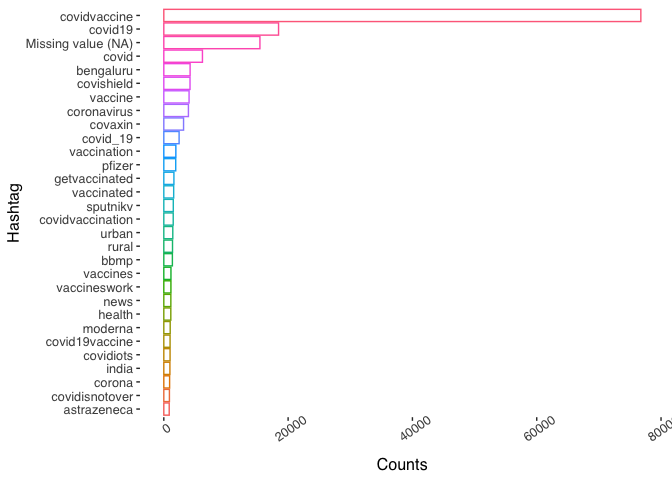

In [ ]:
univar_cat_bar_plot(hashtag_tkns, hashtag, .n_largest = 30)

### 6.3 User verified and retweet status

In [ ]:
tableone::CreateCatTable(
    vars = c('user_verified', 'is_retweet'),
    data = tweets_df) %>%
    tableone::kableone()

From [Table 3](#tbl-user_ver_retweet) we can observe that only about 1
out of every tweets in our data come from an user with verified status.
None of the tweets in our data were flagged as retweets.

## 7 Numerical Data

### 7.1 Favourites, followers, and friends

[Table 4](#tbl-fffs) below provides descriptive statistics for the
number of user favourites, followers, and friends.
[Figure 6](#fig-favourites), [Figure 7](#fig-followers) and
[Figure 8](#fig-friends) provide visualisation of their distribution.
Notice that all three variables are heavily skewed, as one would expect.
All three distribution seem to benefit the most of applying a **log
transformation**, a detail that may be important for modeling. However,
more sophisticated methods, i.e. BoxCox and YeoJohnson, may provide
better results and are worth exploring.

In [ ]:
tweets_df %>%
    dplyr::select(-tweet_id) %>%
    univar_num_table() %>%
    kreate()

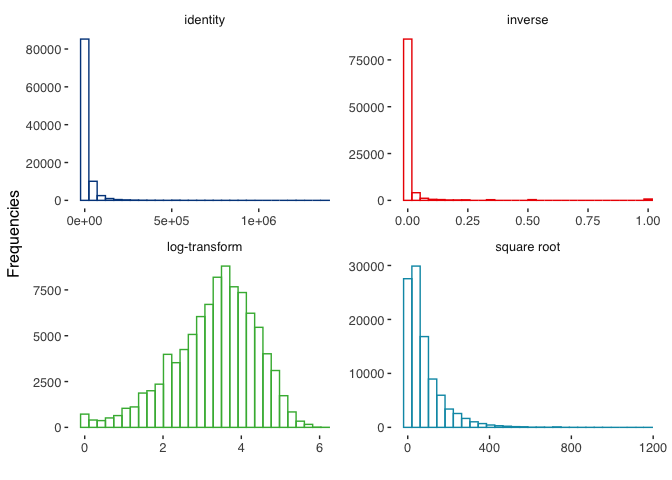

In [ ]:
tweets_df %>%
    transform_dist_plots(user_favourites)

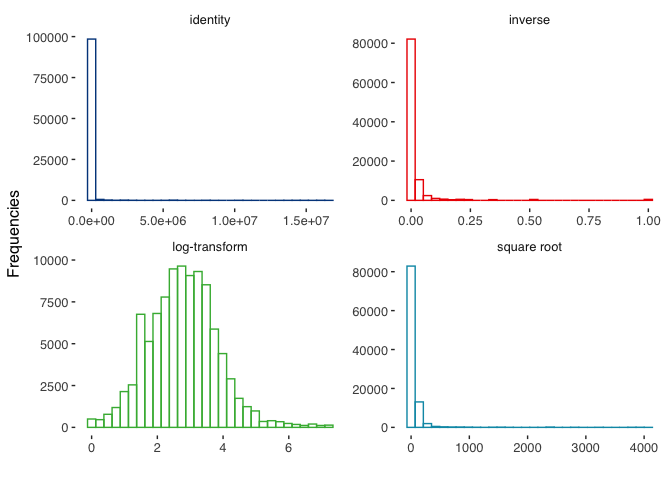

In [ ]:
tweets_df %>%
    transform_dist_plots(user_followers)

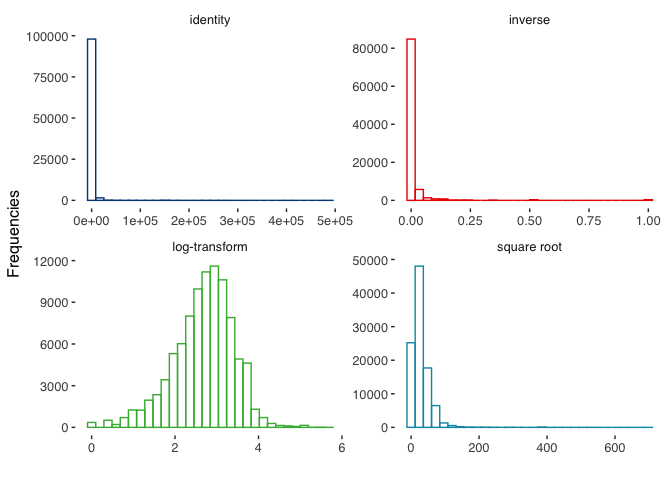

In [ ]:
tweets_df %>%
    transform_dist_plots(user_friends)